# 4. Small Network Model with PointNet

In the last tutorial we built a toy model of the Mouse Visual Cortex system with 75 biophysically detailed neurons, that we ran with BioNet (i.e., the NEURON simulator). This time we will build/convert a similar model but instead using PointNet (i.e., the NEST simulator) with point-neuron-based models. In particular, we will use the Generalized Leaky Integrate-and-Fire (GLIF) models created at the Allen Institute and for which we can find optimized models in the Allen Cell-Types Database.

As we will see the process for building and simulating point-neuron models are similar to biophysically detailed neurons, with the appropriate adjustments.

In [1]:
import os
import shutil
from distutils.dir_util import copy_tree
import numpy as np
import pandas as pd
import nest

from bmtk.builder.networks import NetworkBuilder
from bmtk.simulator import pointnet
from bmtk.analyzer.compartment import plot_traces
from bmtk.analyzer.spike_trains import plot_raster

## Downloading the Models

As before we will first want to find appropiate models using the [Allen Cell-Types Database Feature Search](https://celltypes.brain-map.org/data). We choose 3 different spiny excitatory models (identified by expression of Scnn1a, Rorb, and Nr5a1) and one inhibitory model (identified by expression of PValb) for "Mouse" in the Location "VISp", "L4".

This time we also want to make sure to check the box "Has GLIF Model".

There are actually five different variations of the GLIF model, we are primarily interested in the "type 3: LIF-ASC" models. Choose that from the "Select neuronal model" dropdown, which will bring up the option to "Download model" at the bottom of the page:

<br>
<div>
  <img src="../images/cell_types_db_glif_selection_highlighted.png" width="850" align="left" style="margin-left:4px"/>    
</div>
<br clear="left">

The main file we are looking for is called *neuron_config.json*, which like *fit_parameters.json* for perisomatic models contains the **dynamics_params**. Rename _neuron_config.json_ to something more informative, then copy the file to the *components/point_neuron_models/* directory.

As before we already did this - but feel free to choose your own models.



## Creating the Model

There are two ways we can build a 75 point-neuron version of the L4 model we created in the last chapter.

1. <ins>Copy the morphologically detailed model and adjust parameters manually</ins> - If you already built the model you can just copy the files into the _network/_ directory. This way the cell-positions and connectivity matrix will be exactly the same (otherwise, due to calls to ```np.random```, each time we build the network it is a little different). A number of properties in the _node_types.csv_ and _edge_types.csv_ will need to be adjusted so that BMTK can work with our GLIF models. We can do it in a text editor or even programatically using pandas.


2. <ins>Rebuild the model from scratch</ins> - This will involve using the same ```add_nodes()``` and ```add_edges()``` method we used in the previous chapter. Some properties, like **model_type**, **dynamics_params**, **syn_weight** will need to be adjusted to deal with the fact that we are using completely different models. Other properties like **morphology**, **afferent_section_id**, and **rotation_angle_\*** can be removed completely as they won't apply to point-neurons.

### 1. Copying an existing model

We can copy the previous chapter's network files in the command line:

```bash
$ mkdir -p network_copied
$ cp ../Ch3_multicells/network/* network_copied
```

Or in the notebook:

In [2]:
import os
from distutils.dir_util import copy_tree

os.makedirs('network_copied', exist_ok=True)
copy_tree('../Ch3_multicells/network', 'network_copied')

['network_copied/lif_lif_edges.h5',
 'network_copied/l4_lif_edge_types.csv',
 'network_copied/l4_l4_edges.h5',
 'network_copied/lif_l4_edges.h5',
 'network_copied/lgn_nodes.h5',
 'network_copied/lgn_l4_edges.h5',
 'network_copied/l4_lif_edges.h5',
 'network_copied/lif_lif_edge_types.csv',
 'network_copied/l4_nodes.h5',
 'network_copied/l4_node_types.csv',
 'network_copied/lgn_node_types.csv',
 'network_copied/l4_l4_edge_types.csv',
 'network_copied/lgn_l4_edge_types.csv',
 'network_copied/lif_node_types.csv',
 'network_copied/lif_l4_edge_types.csv',
 'network_copied/lif_nodes.h5']

Then we make the appropiate changes to the l4_nodes_types.csv, which we can do in a text editor or using pandas.

In [3]:
import pandas as pd

node_types_df = pd.read_csv('network_copied/l4_node_types.csv', sep=' ')

# remove unnecessary columns
node_types_df = node_types_df.drop(columns=['model_processing', 'morphology', 
                                            'rotation_angle_xaxis', 'rotation_angle_zaxis'])
# change model properties directive
node_types_df['model_type'] = 'point_neuron'
node_types_df['model_template'] = 'nest:glif_lif_asc_psc'
node_types_df = node_types_df.replace({
    'Scnn1a_485510712_params.json': 'Scnn1a_593618144_glif_lif_asc.json',
    'Rorb_486509958_params.json': 'Rorb_480124551_glif_lif_asc.json',
    'Nr5a1_485507735_params.json': 'Nr5a1_318808427_glif_lif_asc.json',
    'Pvalb_473862421_params.json': 'Pvalb_487667205_glif_lif_asc.json'
})

# save 
node_types_df.to_csv('network_copied/l4_node_types.csv', sep=' ', index=False)

node_types_df

,node_type_id,model_template,model_name,ei_type,dynamics_params,model_type
0,100,nest:glif_lif_asc_psc,Scnn1a,e,Scnn1a_593618144_glif_lif_asc.json,point_neuron
1,101,nest:glif_lif_asc_psc,Rorb,e,Rorb_480124551_glif_lif_asc.json,point_neuron
2,102,nest:glif_lif_asc_psc,Nr5a1,e,Nr5a1_318808427_glif_lif_asc.json,point_neuron
3,103,nest:glif_lif_asc_psc,PValb,i,Pvalb_487667205_glif_lif_asc.json,point_neuron


In [4]:
for et_path in ['network_copied/l4_l4_edge_types.csv', 'network_copied/lgn_l4_edge_types.csv']:
    edge_types_df = pd.read_csv(et_path, sep=' ')
    edge_types_df['model_template'] = 'static_synapse'
    edge_types_df = edge_types_df.replace(
        {'dynamics_params': 'AMPA|GABA'}, 
        {'dynamics_params': 'static'}, 
        regex=True
    )

    # Make it easier to change syn_weight by hand, move 'syn_weight' to end 
    syn_weight = edge_types_df.pop('syn_weight')
    edge_types_df['syn_weight'] = '<TBD>'

    edge_types_df.to_csv(et_path, sep=' ', index=False)

Finally we will want to open our _edge_types.csv_ and modify the **syn_weight** column values. Readjusting synaptic weights when moving from biophysical models to point neuron models, or even between two different model types of the same level, can be very difficult. Although there are some tools in development which may help with parameter optimization of synaptic weights, like [nested](https://github.com/neurosutras/nested), the process often requires a lot of trial-and-error.

We will often have to run multiple iterations of different types of simulations on individual neurons and the network and constantly update **syn_weight** until we can get expected firing rates:

<br>
<div>
  <img src="../images/update_syn_weights.png" width="700" align="left" style="margin-left:4px"/>    
</div>

### 2. Rebuilding the model

The following is a modification of the previous build script for our 75 L4 + 100 LGN network, but designed to run in PointNet. Some things to note:

* The rules for generating coordinates and creating connections between cells (using tuning angle/distance) are the same as with the biophysical model.


* We are no longer using the ```add_properties()``` method to find the sectional placement of the afferent synapse. We still need to know the number of synapses between a source/target pair of cells, but since the cells are just geometric "points" there is only one place we can put the synapses. 


* Our **model_type** will always be "point_neuron". For the nodes' **model_template** we can choose from a number of [available NEST cell models](https://nest-simulator.readthedocs.io/en/v3.2/models/index.html) or even build our own, although we will strictly be using the "glif_psc" model.


* For our edges **model_template** we can also choose from one of the available [built-in synaptic models](https://nest-simulator.readthedocs.io/en/v3.2/models/index_synapse.html) or build our own. For simplicity we will be sticking with the standard "static_synapse" with the synaptic properties for each model saved in the _components/synaptic_models/_ directory.


#### Helper functions

In [5]:
import numpy as np


def get_coords_column(N, radius_min=0.0, radius_max=400.0):
    phi = 2.0 * np.pi * np.random.random([N])
    r = np.sqrt((radius_min**2 - radius_max**2) * np.random.random([N]) + radius_max**2)
    x = r * np.cos(phi)
    y = np.random.uniform(400.0, 500.0, size=N)
    z = r * np.sin(phi)
    return x, y, z


def get_coords_plane(ncells, size_x=240.0, size_y=120.0):
    xs = np.random.uniform(0.0, size_x, ncells)
    ys = np.random.uniform(0.0, size_y, ncells)
    return xs, ys


def exc_exc_rule(source, target, max_syns):
    """Connect rule for exc-->exc neurons, should return an integer 0 or greater. The number of 
    connections will be weighted according to the difference between source and target cells' 
    tuning_angle property"""
    if source['node_id'] == target['node_id']:
        # prevent a cell from synapsing with itself
        return 0
    
    # calculate the distance between tuning angles and use it to choose
    # number of connections using a binomial distribution.
    src_tuning = source['tuning_angle']
    trg_tuning = target['tuning_angle']
    tuning_dist = np.abs((src_tuning - trg_tuning + 180) % 360 - 180)
    probs = 1.0 - (np.max((tuning_dist, 10.0)) / 180.0)
    return np.random.binomial(n=max_syns, p=probs)


def others_conn_rule(source, target, max_syns, max_distance=300.0, sigma=60.0):
    """Connection rule for exc-->inh, inh-->exc, or inh-->inh connections. The number of connections
    will be based on the euclidian distance between source and target cell.
    """
    if source['node_id'] == target['node_id']:
        return 0
    
    dist = np.sqrt((source['x'] - target['x'])**2 + (source['z'] - target['z'])**2)
    if dist > max_distance:
        return 0
    
    prob = np.exp(-(dist/sigma)**2)
    return np.random.binomial(n=max_syns, p=prob)

#### Building the recurrent (l4 --> l4) network

In [6]:
from bmtk.builder.networks import NetworkBuilder


l4 = NetworkBuilder('l4')

# Add nodes
x, y, z = get_coords_column(20)
l4.add_nodes(
    N=20,   
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Scnn1a_515806250_glif_lif_asc.json',   
    x=x, y=y, z=z,
    tuning_angle=np.linspace(start=0.0, stop=360.0, num=20, endpoint=False),
    model_name='Scnn1a',
    ei_type='e'
)


x, y, z = get_coords_column(20)
l4.add_nodes(
    N=20,
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Rorb_512332555_glif_lif_asc.json',
    x=x, y=y, z=z,   
    model_name='Rorb', 
    ei_type='e',
    tuning_angle=np.linspace(start=0.0, stop=360.0, num=20, endpoint=False),
)

x, y, z = get_coords_column(20)
l4.add_nodes(
    N=20,
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Nr5a1_587862586_glif_lif_asc.json',   
    x=x, y=y, z=z,    
    model_name='Nr5a1', 
    ei_type='e',
    tuning_angle=np.linspace(start=0.0, stop=360.0, num=20, endpoint=False),
)

x, y, z = get_coords_column(15)
l4.add_nodes(
    N=15,   
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Pvalb_574058595_glif_lif_asc.json',
    x=x, y=y, z=z, 
    model_name='PValb',
    ei_type='i',
)


# Add recurrent edges
l4.add_edges(
    source=l4.nodes(ei_type='e'),
    target=l4.nodes(ei_type='e'),    
    connection_rule=exc_exc_rule,
    connection_params={'max_syns': 15},
    syn_weight=1.2,
    delay=2.0,
    dynamics_params='static_ExcToExc.json',
    model_template='static_synapse',
)

l4.add_edges(
    source=l4.nodes(ei_type='e'),
    target=l4.nodes(ei_type='i'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': 12},
    syn_weight=7.5,
    delay=2.0,
    dynamics_params='static_ExcToInh.json',
    model_template='static_synapse',
)

l4.add_edges(
    source=l4.nodes(ei_type='i'),
    target=l4.nodes(ei_type='e'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': 14},
    syn_weight=-10.5,
    delay=2.0,
    dynamics_params='static_InhToExc.json',
    model_template='static_synapse',
)

l4.add_edges(
    source=l4.nodes(ei_type='i'),
    target=l4.nodes(ei_type='i'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': 14},
    syn_weight=-2.0,
    delay=2.0,
    dynamics_params='static_InhToInh.json',
    model_template='static_synapse',
)


In [7]:
l4.build()
l4.save(output_dir='network')

#### Building feedforward  (lgn --> l4) inputs

Now we can build our network of "virtual" LGN cells and connect them to the L4 network.

In [8]:
def connect_lgn_cells(source, targets, max_targets, min_syns=1, max_syns=15, lgn_size=(240, 120),
                      l4_radius=400.0, ellipse=(100.0, 500.0)):
    # map the lgn cells from the plane to the circle
    x, y = source['x'], source['y']
    x = x / lgn_size[0] - 0.5
    y = y / lgn_size[1] - 0.5
    src_x = x * np.sqrt(1.0 - (y**2/2.0)) * l4_radius
    src_y = y * np.sqrt(1.0 - (x**2/2.0)) * l4_radius

    # Find (the indices) of all the target cells that are within the given ellipse, if there are more than max_targets
    # then randomly choose them
    a, b = ellipse[0]**2, ellipse[1]**2
    dists = [(src_x-t['x'])**2/a + (src_y-t['y'])**2/b for t in targets]
    valid_targets = np.argwhere(np.array(dists) <= 1.0).flatten()
    if len(valid_targets) > max_targets:
        valid_targets = np.random.choice(valid_targets, size=max_targets, replace=False)

    # create an array of all synapse count. Most targets will have 0 connection, except for the "valid_targets" which
    # will have between [min_syns, max_syns] number of connections.
    nsyns_arr = np.zeros(len(targets), dtype=int)
    for idx in valid_targets:
        nsyns_arr[idx] = np.random.randint(min_syns, max_syns)

    return nsyns_arr

In [9]:
lgn = NetworkBuilder('lgn')

# Build Nodes
x, y = get_coords_plane(50)
lgn.add_nodes(
    N=50,
    x=x,
    y=y,
    model_type='virtual',
    model_template='lgnmodel:tON_TF8',
    dynamics_params='tON_TF8_demo.json',
    ei_type='e'
)

x, y = get_coords_plane(50)
lgn.add_nodes(
    N=50,
    x=x,
    y=y,
    model_type='virtual',
    model_template='lgnmodel:tOFF_TF8',
    dynamics_params='tOFF_TF8_demo.json',
    ei_type='e'
)

# Build Edges
lgn.add_edges(
    source=lgn.nodes(),
    target=l4.nodes(ei_type='e'),
    connection_rule = connect_lgn_cells,
    connection_params = {'max_targets': 6},
    iterator='one_to_all',
    model_template='static_synapse',
    dynamics_params='static_ExcToExc.json',
    delay=2.0,
    syn_weight=11.0
)

lgn.add_edges(
    source=lgn.nodes(),
    target=l4.nodes(ei_type='i'),
    connection_rule=connect_lgn_cells,
    connection_params={'max_targets': 12, 'ellipse': (400.0, 400.0)},
    iterator='one_to_all',
    model_template='static_synapse',
    dynamics_params='static_ExcToInh.json',
    delay=2.0,
    syn_weight=13.0
)


In [10]:
lgn.build()
lgn.save(output_dir='network')

__[SUGGESTION: Visualize in VND]__

### Inputs for LGN

As before we need to provide inputs for our LGN "virtual" cells. We could use the ```bmtk.utils.reports.spike_trains.PoissonSpikeGenerator``` object as was done before. But since the spike-files are the same for BioNet and PointNet we can just copy the existing lgn-spikes:


In [11]:
import os
import shutil

os.makedirs('inputs', exist_ok=True)
shutil.copy('../Ch3_multicells/inputs/lgn_spikes.h5', 'inputs')

'inputs/lgn_spikes.h5'

### Setting up the environment

As before we need to initialize the simulation directory, including configuration files, python run scripts, and the model file components. We've already set this up for you. But if running a PointNet simulation from scratch the following can help using the ```bmtk.utils.create_environment``` helper functions - either through the command line:

```bash
  $ python -m bmtk.utils.create_environment     \
       --config-file config.pointnet.json       \
       --network-dir network                    \
       --output-dir output_pointnet             \
       --tstop 3000.0                           \
       --dt 0.1                                 \
       --report-vars l4:V_m                     \
       --spikes-inputs lgn:inputs/lgn_spikes.h5 \
       --run-script run_pointnet.py             \
       --overwrite                              \
       pointnet .
```

or through python:

In [12]:
from bmtk.utils.create_environment import create_environment

create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet.json',
    network_dir='network',
    output_dir='output_pointnet',
    tstop=3000.0, dt=0.1,
    report_vars=[('l4', 'V_m')],
    spikes_inputs=[('lgn', 'inputs/lgn_spikes.h5')],
    run_script='run_pointnet.py',
    # overwrite=True,
)

ERROR:root:Configuration file /home/kael/Workspace/bmtk_workshop_2022/Ch4_pointnet/config.pointnet.json already exists, skipping. Please delete existing file, use a different name, or use overwrite=True.


### Running the Simulation

We can run our GLIF version of the L4 network through the command line:

```bash
$ python run_pointnet.py config.pointnet.json
```

We can use MPI to run the simulation on multiple cores:
```bash
$ mpirun -np <N> python run_pointnet.py config.pointnet.json
```

or to run it in the notebook:

In [13]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.pointnet.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2022-07-13 12:42:48,831 [INFO] Created log file


INFO:NestIOUtils:Created log file


2022-07-13 12:42:48,842 [INFO] Batch processing nodes for lgn/0.


INFO:NestIOUtils:Batch processing nodes for lgn/0.


2022-07-13 12:42:48,853 [INFO] Batch processing nodes for l4/0.


INFO:NestIOUtils:Batch processing nodes for l4/0.


2022-07-13 12:42:48,855 [INFO] Batch processing nodes for l4/1.


INFO:NestIOUtils:Batch processing nodes for l4/1.


2022-07-13 12:42:48,877 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2022-07-13 12:42:48,879 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2022-07-13 12:42:48,890 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2022-07-13 12:42:48,902 [INFO] Build virtual cell stimulations for lgn_spikes


INFO:NestIOUtils:Build virtual cell stimulations for lgn_spikes


2022-07-13 12:42:49,595 [INFO] Network created.


INFO:NestIOUtils:Network created.


2022-07-13 12:42:49,700 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2022-07-13 12:42:52,870 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2022-07-13 12:42:53,708 [INFO] Done.


INFO:NestIOUtils:Done.


/home/kael/Workspace/bmtk/bmtk/analyzer/spike_trains.py:120: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


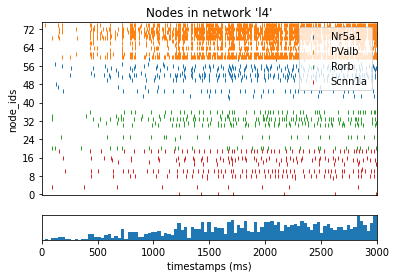

In [14]:
from bmtk.analyzer.spike_trains import plot_raster

_ = plot_raster(config_file='config.pointnet.json', group_by='model_name', show=False)

__[SUGGESTION: Plot Activity in VND]__

## (Optional) PopNet

We've already built a version of our L4 model using multi-compartment biophysically detailed cells in NEURON (BioNet) and point-neuron GLIF-based models in NEST (PointNet). BMTK includes a third simulator engine called PopNet which can be used to simulate population level firing rates using the DiPDE tool.

As before we have two options for building our GLIF Model:
1. Build from scratch using BMTK's NetworkBuilder
2. Copy an existing biophysical/point model and modify the node-types and edge type params


### Building PopNet version of the L4 Model
Some things to take note:
* Populations don't have individual cells so essentially we need **N**=1, which is the same as using the default option.
* For **model_type** we want to use option 'population'.
* Unlike with the Biophysical and GLIF model, there are no optimized DiPDE/PopNet models in the Allen-Cell Types database. Instead we need to build the **dynamics_params** parameter files from scratch (we'll briefly explain the options available).
* There are only two types of **model_templates** for DiPDE/PopNet - "Internal" and "External" (equivalent to virtual cells). 


In [15]:
from bmtk.builder import NetworkBuilder


# Create and Build the L4 model
l4 = NetworkBuilder('l4')
l4.add_nodes(
    model_name='Scnn1a',
    ei_type='e',
    model_type='population',
    model_template='dipde:Internal',
    dynamics_params='Scnn1a_pop_model.json'
)

l4.add_nodes(
    model_name='Rorb',
    ei_type='e',
    model_type='population',
    model_template='dipde:Internal',
    dynamics_params='Rorb_pop_model.json'
)

l4.add_nodes(
    model_name='Nr5a1',
    ei_type='e',
    model_type='population',
    model_template='dipde:Internal',
    dynamics_params='Nr5a1_pop_model.json'
)

l4.add_nodes(
    model_name='Pvalb',
    ei_type='i',
    model_type='population',
    model_template='dipde:Internal',
    dynamics_params='Pvalb_pop_model.json'
)


# Recurrently connect internal populations
def exc_exc_conns(source, target):
    if source['node_id'] == target['node_id']:
        return 0
    else:
        return 2


l4.add_edges(
    source={'ei_type': 'e'}, target={'ei_type': 'e'},
    syn_weight=0.01,
    connection_rule=exc_exc_conns,
    delay=0.002,
    dynamics_params='dipde_ExcToInh.json'

)

l4.add_edges(
    source={'ei_type': 'e'}, target={'ei_type': 'i'},
    syn_weight=0.005,
    nsyns=20,
    delay=0.002,
    dynamics_params='dipde_ExcToInh.json'
)

l4.add_edges(
    source={'ei_type': 'i'}, target={'ei_type': 'e'},
    syn_weight=-0.002,
    nsyns=10,
    delay=0.002,
    dynamics_params='dipde_InhToExc.json'
)

l4.build()
l4.save(output_dir='network_popnet')

Now for our LGN cells:

In [16]:
lgn = NetworkBuilder('lgn')
lgn.add_nodes(
    pop_name='tON',
    ei='e',
    model_type='virtual',
    model_template='dipde:External'
)

# Connect external pop to internal pops
lgn.add_edges(
    source=lgn.nodes(),
    target=l4.nodes(),
    syn_weight=0.0025,
    nsyns=10,
    delay=0.002,
    dynamics_params='dipde_ExcToExc.json'
)

lgn.build()
lgn.save(output_dir='network_popnet')

### Setting up the environment

We can again use our helper function either through the command line

```bash
  $python -m bmtk.utils.create_environment                \
              --config-file config.popnet.json            \
              --network-dir network_popnet                \
              --output-dir output_popnet                  \
              --tstop 3000.0                              \
              --dt 0.002                                  \
              --rates-inputs lgn:inputs/lgn_pop_rates.csv \
              --run-script run_popnet.py                  \
              --overwrite                                 \
              popnet .

```

or in python

In [17]:
from bmtk.utils.create_environment import create_environment

create_environment(
    'popnet',
    base_dir='.',
    config_file='config.popnet.json',
    network_dir='network_popnet',
    output_dir='output_popnet',
    tstop=3000.0, dt=0.002,
    rates_inputs=[('lgn', 'inputs/lgn_pop_rates.csv')],
    run_script='run_popnet.py',
    # overwrite=True,
)

ERROR:root:Configuration file /home/kael/Workspace/bmtk_workshop_2022/Ch4_pointnet/config.popnet.json already exists, skipping. Please delete existing file, use a different name, or use overwrite=True.


#### Inputs

Unlike BioNet and PointNet, PopNet is not a spiking simulator and instead records the changes in firing-rates. As such the inputs to the LGN External files are not expecting individual spike-train files, but rather a list of firing rates for the External populations (currently firing rates must be constant, not time varying).

<table style="float:left; border:1px solid black">
  <tr>
    <th style='text-align: center;border:1px solid black'>node_id</th>
    <th style='text-align: center;border:1px solid black'>firing_rate</th>
  </tr>
  <tr>
      <td style='text-align: center;border:1px solid black'>100</td>
      <td style='text-align: center;border:1px solid black'>15.0</td>
  </tr>
</table>
<br clear='left'>

And the "inputs" section of the config file should look like the following:
```json
{
    "inputs": {
        "lgn_rates": {
            "input_type": "csv",
            "module": "pop_rates",
            "rates": "$BASE_DIR/inputs/lgn_pop_rates.csv",
            "node_set": "lgn",
        }   
    }
}
```

We can run the PopNet simulation in either command-line:

```bash
$ python run_popnet.py config.popnet.json
```

or in the notebook:

In [ ]:
from bmtk.simulator import popnet

configure = popnet.config.from_json('config.popnet.json')
configure.build_env()

network = popnet.PopNetwork.from_config(configure)
sim = popnet.PopSimulator.from_config(configure, network)
sim.run()

2022-07-13 12:42:54,768 [WARNING] Directory /home/kael/Workspace/bmtk_workshop_2022/Ch4_pointnet/output_popnet already exists.


2022-07-13 12:42:54,769 [INFO] Created log file


INFO:IOUtils:Created log file


2022-07-13 12:42:54,804 [INFO] Building cells.


INFO:IOUtils:Building cells.


2022-07-13 12:42:54,807 [INFO] Building recurrent connections


INFO:IOUtils:Building recurrent connections


2022-07-13 12:42:54,834 [INFO] Build virtual cell stimulations for lgn_rates


INFO:IOUtils:Build virtual cell stimulations for lgn_rates


2022-07-13 12:42:54,848 [INFO] Network created.
2022-07-13 12:42:54,849 [INFO] Running simulation.


In [ ]:
from bmtk.analyzer.firing_rates import plot_rates_popnet

plot_rates_popnet(
    cell_models_file='network_popnet/l4_node_types.csv', 
    rates_file='output_popnet/spike_rates.csv', 
    model_keys='model_name'
)